# CNN for Classification
### Load the data

In [25]:
# our basic libraries
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import os
os.chdir(r'C:\Users\Gebruiker\PycharmProjects')



# The output of torchvision dataset are PILimage images of range [0, 1]
# We transform them to Tersors for input into a CNN

## Define a transform to read the data in as ternsor
data_transform = transforms.ToTensor()

# choose the training and test datasets
train_data = FashionMNIST(root='./data', train=False, download=True,
                          transform=data_transform)

test_data = FashionMNIST(root='./data', train=False, download=True,
                         transform=data_transform)
# Print out some stats about the training data
print(f'Train data, number of images: { len(train_data)}')
print(f'Test data, number of images: { len(test_data)}')

Train data, number of images: 10000
Test data, number of images: 10000


### Data iteration and batching
We'll use torch.utils.data.DataLoader, which is an iterator that allows
us to batch and shuffle data.

In [26]:
# prepare data loaders, set the batch_size

batch_size= 10
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize some training data
This cell iterates over the training dataset, loading a random batch of image
label data, using dataiter.next(). It then plots the batch of images and labels
in a 2x 2 batch_size.2 grid.

<ipython-input-27-1f347a8e88fe>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])


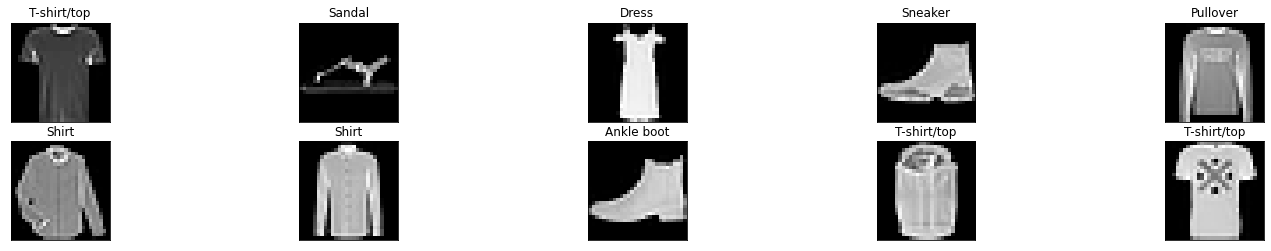

In [27]:
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

### Define the network architecture

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # 1 input image channel (grayscale), 10 output channels / feature maps
        # 3x3 square convolution kernel
        # 1x28x28 => 10x26x26
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=10,
                               kernel_size=3)

        # define a MaxPool2d layer
        # 10x26x26 => 10x13x13
        self.maxpool2d_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define a dropout layer
        self.drop1 = nn.Dropout(p=0.4)

        # Define the second convolutional layer
        # 10x13x13 => 20x11x11
        self.conv2 = nn.Conv2d(in_channels=10,
                               out_channels=20,
                               kernel_size=3)

        # define a MaxPool2d layer
        # 20x11x11 => 20x5x5
        self.maxpool2d_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define a dropout layer
        self.drop2 = nn.Dropout(p=0.3)

        # 20x5x5 => 1x500 (flattered vector)
        self.full_connected_1 = nn.Linear(20*5*5, 32)

        # 512 => 10
        self.full_connected_2 = nn.Linear(32, 10)


    # Define the feedforward behavior
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool2d_1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool2d_2(x)

        # prepare for the linear layer
        #flatten the inputs into a vector
        x = x.view(x.size(0), -1)

        x = self.drop1(x)
        x = self.full_connected_1(x)

        x = self.drop2(x)
        x = self.full_connected_2(x)
        x = F.log_softmax(x, dim=1)

        return x

# instantiate and print your net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2d_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2d_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.3, inplace=False)
  (full_connected_1): Linear(in_features=500, out_features=32, bias=True)
  (full_connected_2): Linear(in_features=32, out_features=10, bias=True)
)


### Specify the loss function and optimizer
Nothe hat for a classification problem like this, one typically uses cross entropy loss,
which can be defined in code like:
* criterion = nn.CrossEntropyLoss();
Cross entropy loss combines softmax and NLL loss so, alternatively (as in this example), you may see NLL
Loss being used when the output of out Net is a distribution of class scores.

PyTorch also includes some standard stochastic optimizers like stochastic gradient descent and Adam.

In [29]:
import torch.optim as optim

# specify loss function
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### A note on accuracy
It's interesting to look at the accuracy of your network before and after training.
This way you can really see that your network has learned something. In the next cell, let's see that
your network has learned something. In the next cell, lets see what the accuracy of an untrained network
is  (we expect it ot be around 10% which is the same accuracy as just guessing for all 10 classes)

In [30]:
# Calculate accuracy before training
correct = 0
total = 0

# Iterate through test dataset
for images, labels in test_loader:

    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = net(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# Calculate the accuracy
# to convert 'correct' from a tensor in to a scalar, use .item
accuracy = 100.0 * correct.item() / total

# Print it out
print(f'Accuracy before training: {accuracy}')

Accuracy before training: 12.19


### Train the Network
Here are the steps that this training function performs as it iterates overthe training dataset:
* Wraps all tensors in Variables;
* Zero's the gradients to prepare for a forward pass;
* Passes the input through the network (forward pass);
* Computes the loss (how far is the predicted classes are from the correct labels);
* Updates the weights (parameter update);
* Prints out the calculated loss;

In [31]:
from torch.autograd import Variable

def train(n_epochs):
    print('Starting the training...')
    loss_over_time = [] # to track the loss as the network trains

    for epoch in range(n_epochs): # Loop over the dataset multiple times

        running_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # wrap them in a torch Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = net.forward(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print(f'Epoch: {epoch + 1}, Batch: {batch_i+1}, Avg. Loss: {avg_loss}')
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time


In [32]:
# define the number of epochs to train for
n_epochs = 12 # start small to see if your model works, initially

# call train
training_loss = train(n_epochs)

Starting the training...
Epoch: 1, Batch: 1000, Avg. Loss: 1.6605419511497022
Epoch: 2, Batch: 1000, Avg. Loss: 1.0080482287406922
Epoch: 3, Batch: 1000, Avg. Loss: 0.8517104297578335
Epoch: 4, Batch: 1000, Avg. Loss: 0.7570109293013811
Epoch: 5, Batch: 1000, Avg. Loss: 0.7148953779265285
Epoch: 6, Batch: 1000, Avg. Loss: 0.6868566989898681
Epoch: 7, Batch: 1000, Avg. Loss: 0.6668094763159752
Epoch: 8, Batch: 1000, Avg. Loss: 0.6415939992442727
Epoch: 9, Batch: 1000, Avg. Loss: 0.6365253316834569
Epoch: 10, Batch: 1000, Avg. Loss: 0.6156944485157728
Epoch: 11, Batch: 1000, Avg. Loss: 0.6102769853770733
Epoch: 12, Batch: 1000, Avg. Loss: 0.5998566555604339
Finished Training


### Visualizing the loss
A good indication of how much your network is learning as it trains is the loss over time.
In this example, we printed and recorded the average loss for each 1000 batches and for each epoch.

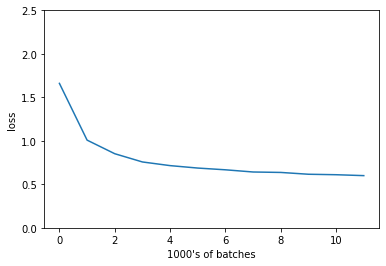

In [33]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5) # consistent scale
plt.show()

### Test the trained Network
Once you are satisfied with how the loss of your model has decreased, there is on last step: test!
You must test your trained model on a previously unseen dataset to see if it generalizes well and can
accurately classify this new dataset. For FashionMNIST, which contains many pre-precessed training
images, a good model should reach greater than 85% accuracy on this test dataset.

In [34]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    # get the input and their corresponding labels
    inputs, labels = data

    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)

    # update average test loss
    test_loss += ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))

    # get the predicted class from the maximum value in the output-list
    # of class scores
    _, predicted = torch.max(outputs.data, 1)

    # compare predictions to true label
    # this creates a 'correct' Tensor that holds the number of
    # correctly classifies images in a batch_size
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))

    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))


print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.476607

Test Accuracy of T-shirt/top: 82% (823/1000)
Test Accuracy of Trouser: 96% (964/1000)
Test Accuracy of Pullover: 75% (750/1000)
Test Accuracy of Dress: 85% (859/1000)
Test Accuracy of  Coat: 77% (773/1000)
Test Accuracy of Sandal: 94% (945/1000)
Test Accuracy of Shirt: 29% (292/1000)
Test Accuracy of Sneaker: 91% (913/1000)
Test Accuracy of   Bag: 96% (963/1000)
Test Accuracy of Ankle boot: 94% (948/1000)

Test Accuracy (Overall): 82% (8230/10000)


### Visualize sample test results
Format: predicted class (true class)

<ipython-input-35-7b847d5ee105>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])


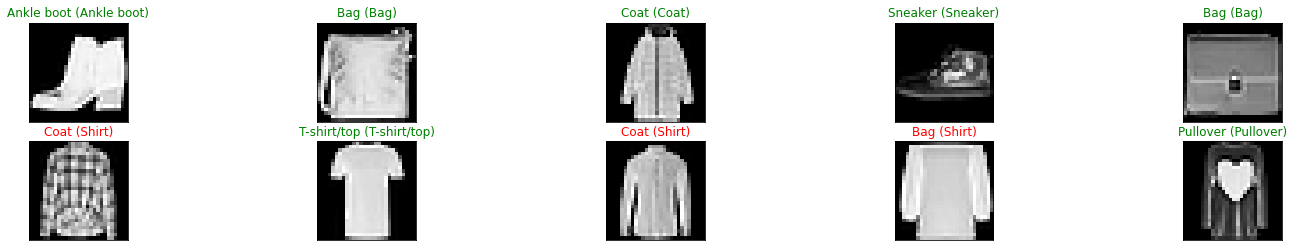

In [35]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [37]:
# Saving the model
model_dir = 'models/'
model_name = 'fashion_net_simple.pt'

# after training, save your model parameters in the dir 'model'
torch.save(net.state_dict(), model_dir + model_name)

FileNotFoundError: [Errno 2] No such file or directory: 'models/fashion_net_simple.pt'

In [49]:
os.path.isdir(r'/models')

False

In [41]:
os.getcwd()


'C:\\Users\\Gebruiker\\PycharmProjects'

In [51]:
os.listdir()

['ComputerVision', 'data', 'pythonProject']